In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import openturns as ot
import matplotlib.pyplot as plt
import ctbenchmark as ctb
import otkerneldesign as otkd

In [3]:
from matplotlib import rc, rcParams, style
#style.use('default')
rcParams['text.usetex'] = True
#rcParams['text.latex.unicode'] = True
rc('font', **{'family': 'Times'})
rc('text', usetex=True)
rc('font', size=16)# Set the default text font size
rc('axes', titlesize=20)# Set the axes title font size
rc('axes', labelsize=16)# Set the axes labels font size
rc('xtick', labelsize=14)# Set the font size for x tick labels
rc('ytick', labelsize=16)# Set the font size for y tick labels
rc('legend', fontsize=16)# Set the legend font size

In [4]:
import scipy.io
mat = scipy.io.loadmat('yutian_mixture.mat')

# Gaussian mixture

In [5]:
problem = ctb.CentralTendencyGaussianMixture()
function = problem.getFunction()
distribution = problem.getDistribution()
problem_name = problem.getName()

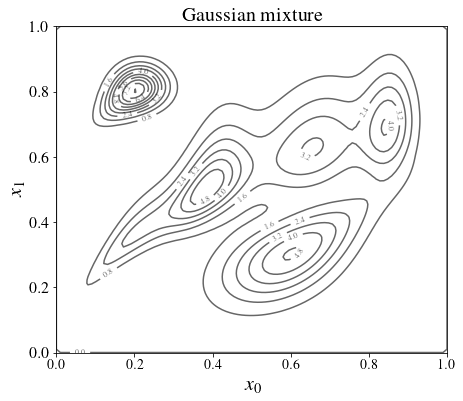

In [6]:
d = ctb.DrawFunctions()
fig = d.draw_2D_controur('Gaussian mixture', None, distribution, nb_isocurves=12, contour_values=True)

In [7]:
2**13

8192

In [8]:
dimension = distribution.getDimension()
size = 50
candidate_set_size = int(2**13)
seq = ot.SobolSequence(distribution.getDimension())
sobol_experiment = ot.LowDiscrepancyExperiment(seq, distribution, candidate_set_size, False)
candidate_set = sobol_experiment.generate()
#candidate_set = distribution.getSample(candidate_set_size)

In [9]:
ker_list = [ot.MaternModel([0.1], [1.0], 2.5)] * dimension
kernel = ot.ProductCovarianceModel(ker_list)

In [10]:
kh = otkd.KernelHerding(
    kernel=kernel,
    candidate_set=candidate_set,
    #distribution=distribution
)
kh_design = kh.select_design(size)

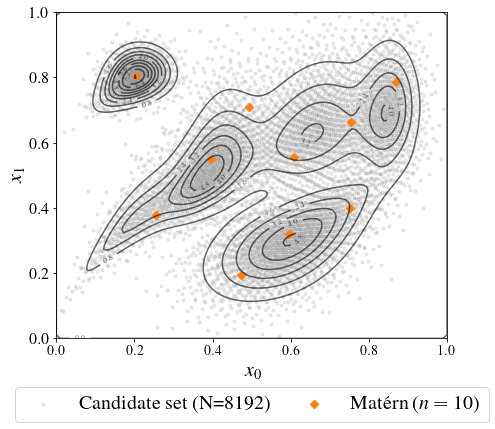

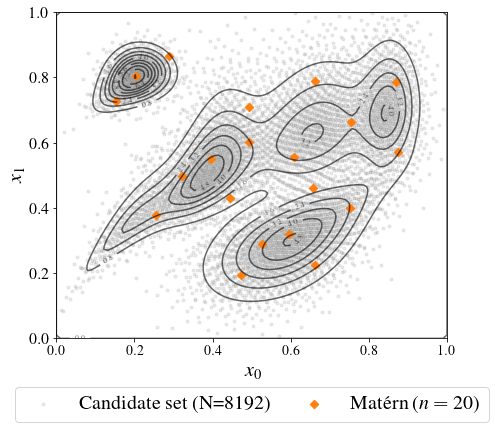

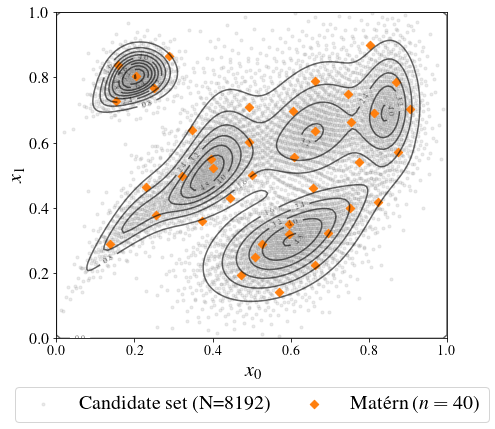

In [11]:
for size in [10, 20, 40]:
    fig = d.draw_2D_controur('', None, distribution, nb_isocurves=12)
    plt.scatter(candidate_set[:, 0], candidate_set[:, 1], label='Candidate set (N={})'.format(candidate_set_size), marker='.', alpha=0.15, color='C7')
    plt.scatter(kh_design[:size, 0], kh_design[:size, 1], label='Matérn ($n={}$)'.format(size), marker='D', color='C1')
    plt.legend(bbox_to_anchor=(0.5, -0.12), loc='upper center', ncol=2, columnspacing=1.2, fontsize=20)
    #plt.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center') # outside bounds
    plt.savefig('res/gaussian_mixture_sampling{}.pdf'.format(size), bbox_inches='tight');
plt.show()

/home/g88077/miniconda4/envs/uqwind/lib/python3.10/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/g88077/miniconda4/envs/uqwind/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/g88077/miniconda4/envs/uqwind/lib/python3.10/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, Futu

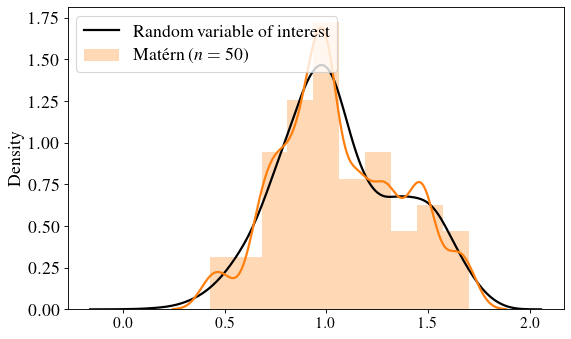

In [12]:
import seaborn as sns
output_rv = problem.getRandomVector()
output_sample = np.array(output_rv.getSample(10000)).flatten()
output_kh = kh_design[:, 0] + kh_design[:, 1]
kwargs = dict(hist_kws={'color':'C1', 'alpha':.3}, kde_kws={'color':'C1', 'bw':0.2, 'linewidth':2})
plt.figure(figsize=(8,5), dpi= 80)
sns.kdeplot(output_sample, color='k', linewidth=2, bw=0.2, label="Random variable of interest")
sns.distplot(output_kh, color="C0", bins=10, **kwargs, label="Matérn ($n={}$)".format(len(output_kh)))
plt.savefig('res/gaussian_mixture_histo.pdf', bbox_inches='tight');
plt.legend(loc='upper left');

## Benchmark

In [13]:
x_bench_sizes = list(range(6, 20, 2)) + list(range(20, 50, 5)) + list(range(50, 100, 10)) + list(range(100, 200, 50)) + list(range(200, 1000, 100))
#x_bench_sizes = list(range(6, 20, 2)) + list(range(20, 50, 5)) + list(range(50, 100, 10))
#my_methods = ['kernel herding', 'support points', 'sobol', 'akda']
my_methods = ['Matérn', 'Gaussian', 'Energy-distance', 'QMC']
bench = ctb.CentralTendencyBenchmark(my_methods, x_bench_sizes)

In [14]:
bench.scale_coefficient = 0.3
df_benchmark = bench.run_benchmark([problem], candidate_set)
df_benchmark = df_benchmark.reset_index()
df_benchmark.to_csv('res/ct_benchmark_{}.csv'.format(problem_name), index=False)

START: problem=Gaussian Mixture | method=Matérn
START: problem=Gaussian Mixture | method=Gaussian
START: problem=Gaussian Mixture | method=Energy-distance
START: problem=Gaussian Mixture | method=QMC
DONE: problem=Gaussian Mixture | method=QMC
DONE: problem=Gaussian Mixture | method=Energy-distance
DONE: problem=Gaussian Mixture | method=Gaussian
DONE: problem=Gaussian Mixture | method=Matérn


In [15]:
#df_benchmark = pd.read_csv("res/ct_benchmark_Gaussian Mixture.csv")
#df_benchmark

## Mean convergence

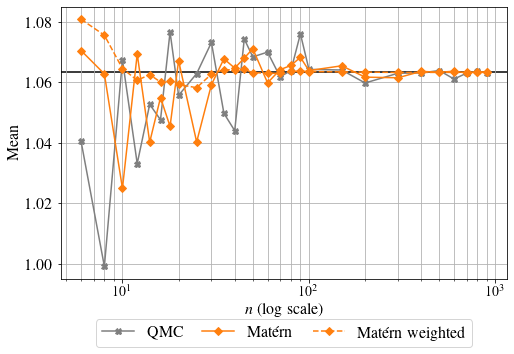

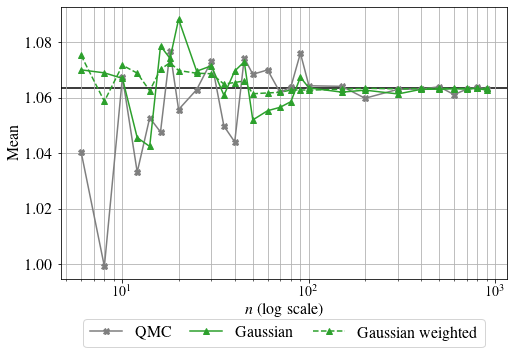

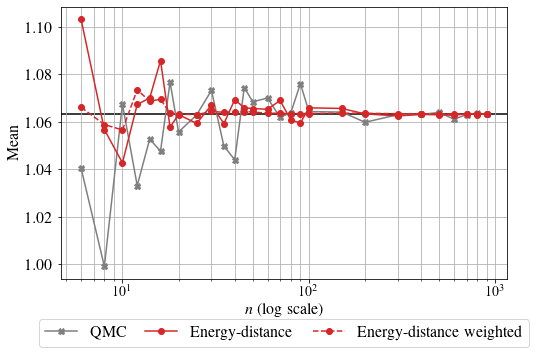

In [16]:
sfile = 'res/{}_convergence_Matern.pdf'.format(problem_name)
figure = bench.plot_ct_benchmark(df_benchmark, problem_name, methods=['QMC', 'Matérn'], save_file=sfile)
sfile = 'res/{}_convergence_Gaussian.pdf'.format(problem_name)
figure = bench.plot_ct_benchmark(df_benchmark, problem_name, methods=['QMC', None, 'Gaussian'], save_file=sfile)
sfile = 'res/{}_convergence_ED.pdf'.format(problem_name)
figure = bench.plot_ct_benchmark(df_benchmark, problem_name, methods=['QMC', None, None, 'Energy-distance'], save_file=sfile);

## MMD convergence

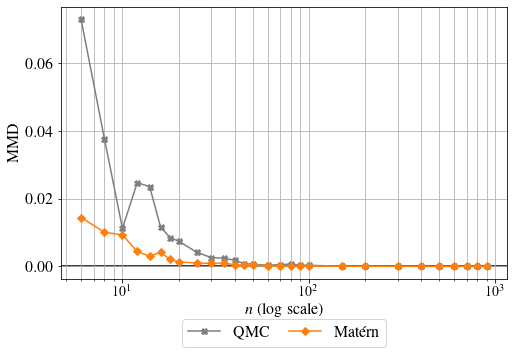

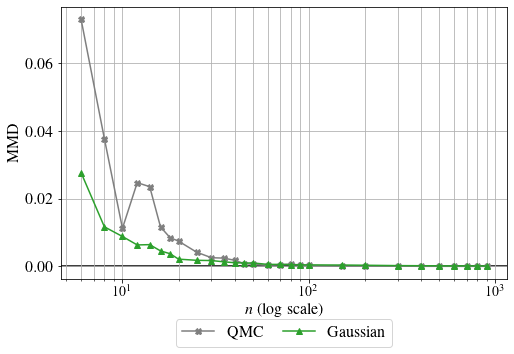

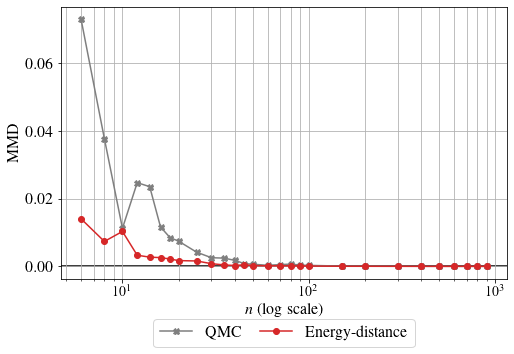

In [17]:
sfile = 'res/{}_convergence_MMD_Matern.pdf'.format(problem_name)
figure = bench.plot_ct_benchmark(df_benchmark, problem_name, methods=['QMC', 'Matérn'], is_MMD=True, save_file=sfile)
sfile = 'res/{}_convergence_MMD_Gaussian.pdf'.format(problem_name)
figure = bench.plot_ct_benchmark(df_benchmark, problem_name, methods=['QMC', None, 'Gaussian'], is_MMD=True, save_file=sfile)
sfile = 'res/{}_convergence_MMD_ED.pdf'.format(problem_name)
figure = bench.plot_ct_benchmark(df_benchmark, problem_name, methods=['QMC', None, None, 'Energy-distance'], is_MMD=True, save_file=sfile);